## XGBoost: Predicting Trip Duration Using Machine Learning
By: Olamilekan Razak Elegbede

This notebook focuses on developing an Extreme Gradient Boosting (XGBoost) regression model with that can accurately predict ride durations and estimate fares using historical trip data.

In [ ]:
# import libraries
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for geographic distance calculations
from geopy.distance import geodesic # pl

# for machine learning model preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

# additional tools for model tuning and evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# XGBoost library for regression modeling
from xgboost import XGBRegressor, plot_importance
import xgboost as xgb

# for saving and loading model objects
import pickle

In [ ]:
# Import cleaned data
data = pd.read_csv(r'./Data/Cleaned Dataframe.csv')

In [3]:
# take a sample of 500k rides
sample = data.sample(n = 500000, random_state=32)
sample.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,Name,holiday,start_date_hour,datetime,conditions,icon,temp,humidity,windspeed,temp_feel
1030434,883FF4D7B6BD6B39,classic_bike,2021-05-11 09:00:20,2021-05-11 09:17:58,Rush St & Cedar St,KA1504000133,LaSalle St & Adams St,KA1503000034,41.902309,-87.627691,...,NaN,Not Holiday,2021-05-11 09:00:00,2021-05-11 09:00:00,Partially cloudy,partly-cloudy-day,8.9,51.61,6.8,Cold
5009399,15A34EC0E90EAA71,classic_bike,2021-10-12 18:00:16,2021-10-12 18:06:05,Clark St & Schreiber Ave,KA1504000156,Glenwood Ave & Morse Ave,KA1504000175,41.999252,-87.671377,...,NaN,Not Holiday,2021-10-12 18:00:00,2021-10-12 18:00:00,Partially cloudy,partly-cloudy-day,18.2,73.09,8.0,Cool


### Data Cleaning
Full Data Cleaning was done prior [Check Data Cleaning Notebook]

If the start and end position is the same we disregard the trip.

In [4]:
# round the start and end positions for accuracy
sample.loc[:,['start_lat','start_lng','end_lat','end_lng']] = sample.loc[:,['start_lat','start_lng','end_lat','end_lng']].round(4)

# Drop rows where start_lat and start_lng are equal to end_lat and end_lng
sample = sample[~((sample['start_lat'] == sample['end_lat']) & (sample['start_lng'] == sample['end_lng']))
].reset_index(drop=True)

# Handle the outliers - Just want rides longer than a minute.
df = sample[sample['ride_duration'] >= 60].reset_index(drop=True)


### EDA

<Figure size 1000x600 with 0 Axes>

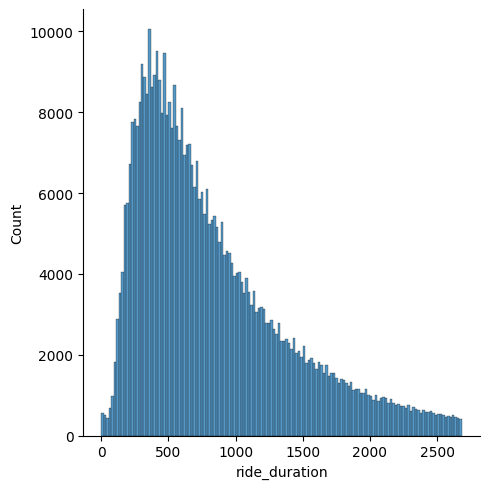

In [5]:
# for continuos labels
plt.figure(figsize=(10,6))
sns.displot(sample['ride_duration'])

Plot the ride duration from each station

<Axes: title={'center': 'Ride Duration by Station'}, xlabel='start_lng', ylabel='start_lat'>

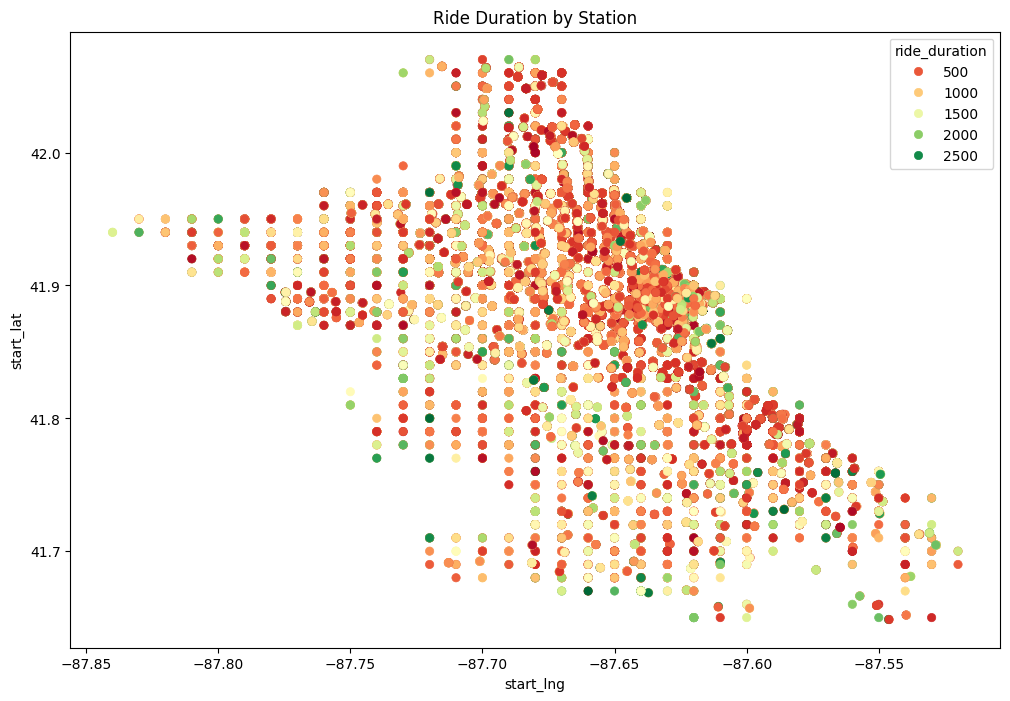

In [52]:
plt.figure(figsize = (12,8))
plt.title('Ride Duration by Station')
sns.scatterplot(x ='start_lng',y = 'start_lat',data = df, 
hue = 'ride_duration', edgecolor = None, palette='RdYlGn')

We don't see a clear geographical pattern with the lcation and the ride duration across all stations, but we can see a clear concentration of low duration/shorter trips in the 'downtown' area.

Text(0.5, 1.0, 'Distribution of Ride Duration by Member Type')

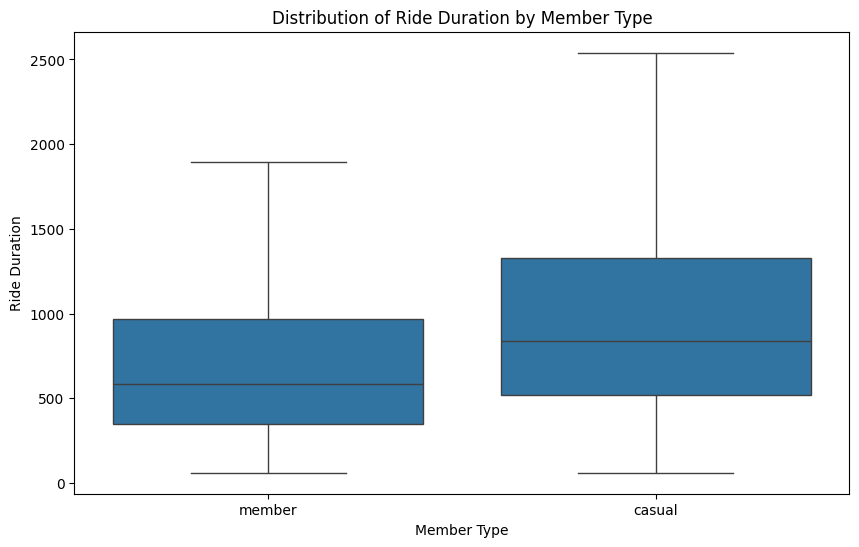

In [7]:
# check duration by member type
plt.figure(figsize = (10,6))
sns.boxplot(x = 'member_casual', y = 'ride_duration', data = df, showfliers=False)
plt.xlabel('Member Type')
plt.ylabel('Ride Duration')
plt.title('Distribution of Ride Duration by Member Type')

From the distribution, we can see that casual users often take longer trips than members.

### Feature Engineering

Calculate the distance between stations from their start/end position, (we are just considering the position not the route)

In [8]:
# calculate a distance columns
def get_distance(row):

    start_coord = (row['start_lat'], row['start_lng'])
    end_coord = (row['end_lat'], row['end_lng'])

    distance = geodesic(start_coord, end_coord).kilometers
    return distance

# apply the function
df['distance'] = df.apply(get_distance, axis=1)

In [9]:
# Extract the month from the date
df['start_day'] = pd.to_datetime(df['start_day'])
df['month'] = df['start_day'].dt.month

# Drop columns
df.drop(columns=['ride_id','started_at','ended_at','start_station_name','end_station_name','start_station_id','end_station_id','start_date_hour',
                 'start_day','datetime','conditions','temp_feel','start_date','Date','Day','Name'],axis=1, inplace=True)

### Feature Encoding

In [ ]:
df['rideable_type'] = df['rideable_type'].map({'classic_bike':0, 'electric_bike':1, 'docked_bike':2})
df['season'] = df['season'].map({'Winter':1, 'Spring':2, 'Summer':3, 'Fall':4})
df['holiday'] = df['holiday'].map({'Holiday':1, 'Not Holiday':0})
df['icon'] = df['icon'].map({'cloudy':0, 'partly-cloudy-day':1, 'clear-day':2, 'clear-night':2,
        'partly-cloudy-night':1, 'rain':4, 'snow':5, 'fog':6, 'wind':7})
df['time_of_day'] = df['time_of_day'].map({'Early Morning':0, 'Morning':1, 'Afternoon':2, 
                                                         'Evening':3, 'Night':4})  
df['day'] = df['day'].map({'Monday':0,'Tuesday':1,'Wednesday':2,'Thursday':3,
                                      'Friday':4,'Saturday':5, 'Sunday':6})
df['member_casual'] = df['member_casual'].map({'member':1, 'casual':0})

df.rename(columns={'day':'weekday','icon':'weather_condition'}, inplace=True)

df.head(2)

,rideable_type,start_lat,start_lng,end_lat,end_lng,member_casual,weekday,month,ride_duration,hour,time_of_day,season,holiday,weather_condition,temp,humidity,windspeed,distance
0,0,41.9023,-87.6277,41.8793,-87.6320,1,1,5,1058.0,9,1,2,0,1,8.9,51.61,6.8,2.579442
1,0,41.9993,-87.6714,42.0080,-87.6655,1,1,10,349.0,18,3,4,0,1,18.2,73.09,8.0,1.082925


#### Correlations between features

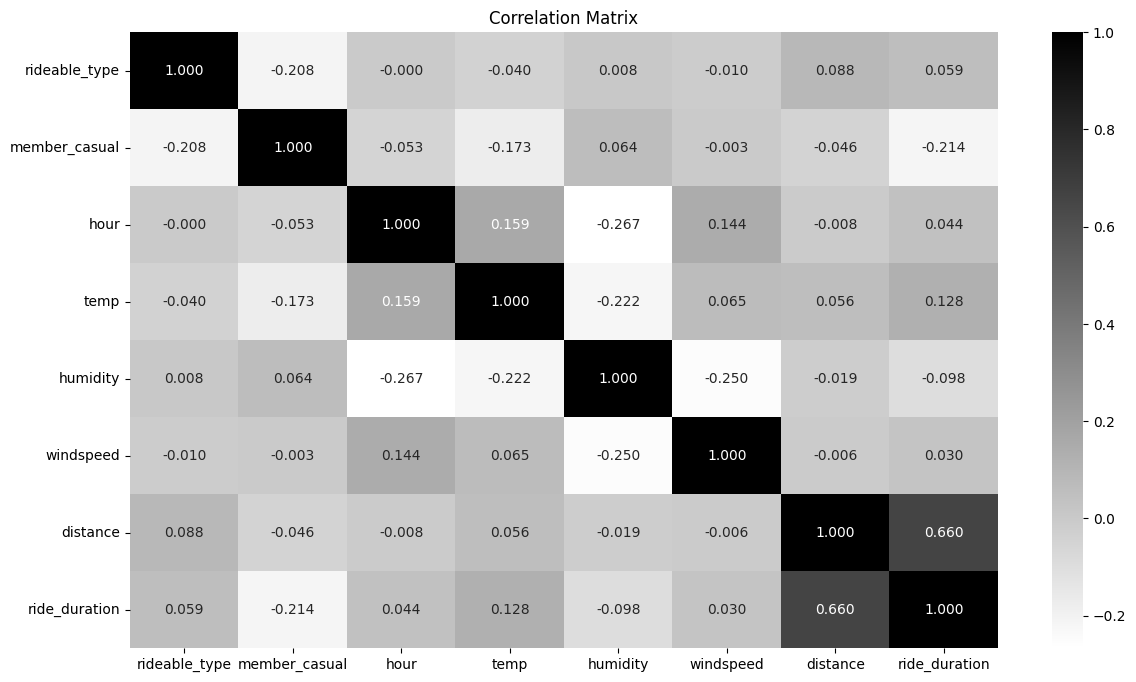

In [11]:
thevariables = ['rideable_type','member_casual','hour','temp', 'humidity', 'windspeed','distance','ride_duration']
plt.figure(figsize=(14,8))
corr = df[thevariables].corr()
sns.heatmap(corr, annot=True, cmap='binary',
            fmt ='.3f',
            xticklabels=thevariables,
            yticklabels=thevariables)
plt.title('Correlation Matrix')
plt.show()

Text(0.5, 1.0, 'Features Correlation with the Target Variable')

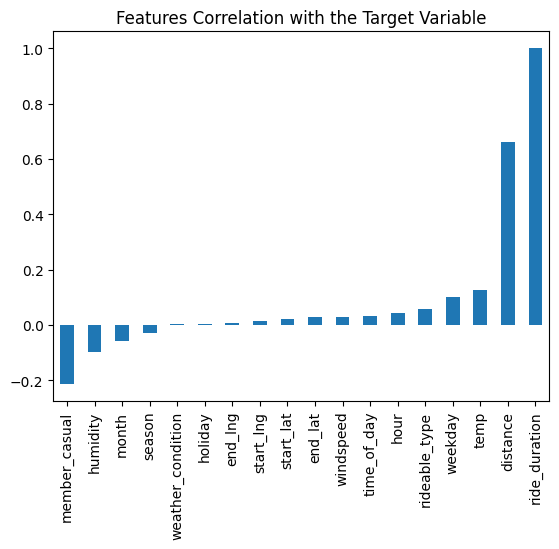

In [12]:
df.corr()['ride_duration'].sort_values().plot(kind='bar')
plt.title('Features Correlation with the Target Variable')

Correlation between the ride duration and the distance between stations.

Text(0.5, 1.0, 'Ride Duration and Distance Correlation')

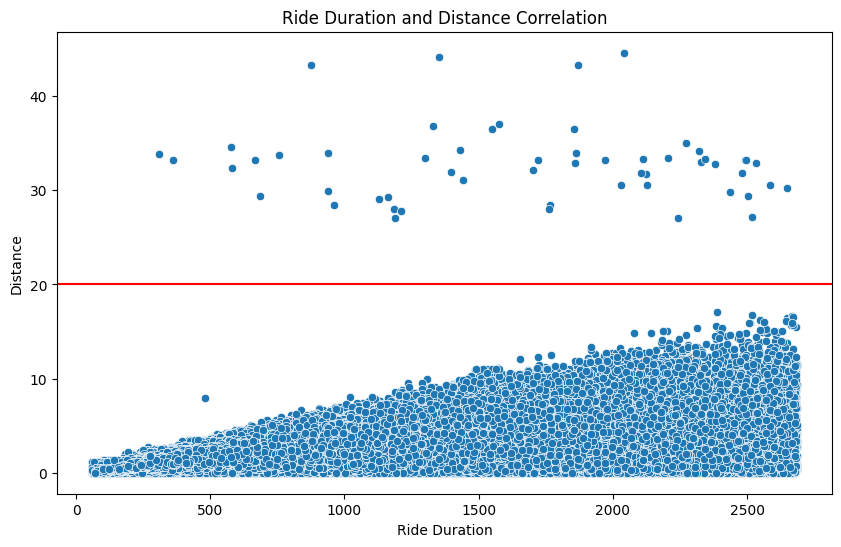

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = 'ride_duration', y='distance', data = df)
plt.axhline(y=20, color = 'red')
plt.xlabel('Ride Duration')
plt.ylabel('Distance')
plt.title('Ride Duration and Distance Correlation')

We can see, some outlier data in the distance column from when the distance between stations is  > 20km. So we can drop those.

In [14]:
# drop outliers distance > 20km
df = df[df['distance'] <= 20].reset_index(drop=True)

### Data Preprocessing

In [15]:
# Features
X = df.drop(columns=['ride_duration'], axis = 1).values

# target label
y = df['ride_duration'].values

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 101)

Scale Data

In [16]:
scaler = MinMaxScaler()

# fit and transform on training test
X_train = scaler.fit_transform(X_train)

# transform the test set
X_test = scaler.transform(X_test)

### Model Building

In [17]:
model = XGBRegressor(objective='reg:squarederror')

Tuning Model

In [18]:
# hyperparameter 
cv_params = {'max_depth': [4,5,6,7,8],
             'learning_rate': [0.1,0.2,0.3],
             'n_estimators':[300,400,500]}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

# Instantiate gridsearc
xgb_cv = GridSearchCV(model, cv_params, scoring=scoring, cv=5, refit='MAE')

# fit the model
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [300, 400, 500]},
             refit='MAE',
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'),
                      'R2': make_scorer(r2_score, response_method='predict')})

### Model Results and Evaluation

In [19]:
# get predictions
predictions = xgb_cv.predict(X_test)

# Evaluate the model
print(f'MAE: {metrics.mean_absolute_error(y_test, predictions)}')
print(f'MSE: {metrics.mean_squared_error(y_test, predictions)}')
print(f'RMSE: {metrics.root_mean_squared_error(y_test, predictions)}')
print(f'Explained Variance Score: {metrics.explained_variance_score(y_test, predictions)}')

MAE: 225.9276677177983
MSE: 121746.71837925745
RMSE: 348.9222239686911
Explained Variance Score: 0.613548899440116


Plot the feature importance of our model.

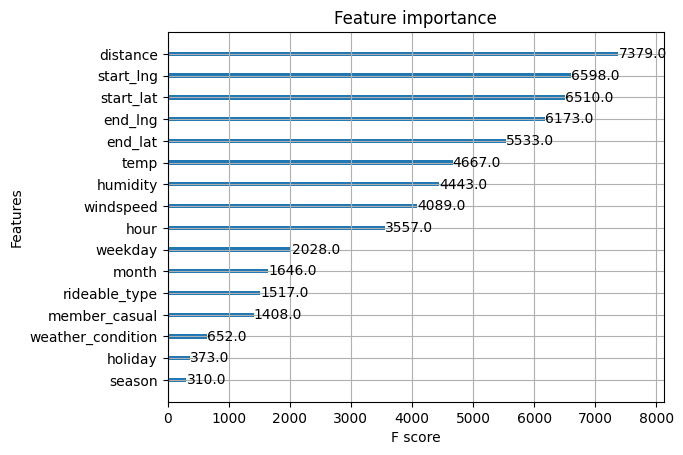

In [39]:
best_model = xgb_cv.best_estimator_

feature_names = ['rideable_type', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'weekday', 'month', 'hour',
       'time_of_day', 'season', 'holiday', 'weather_condition', 'temp',
       'humidity', 'windspeed', 'distance']

best_model.get_booster().feature_names = feature_names

xgb.plot_importance(best_model)
plt.show()

Check residual distribution.

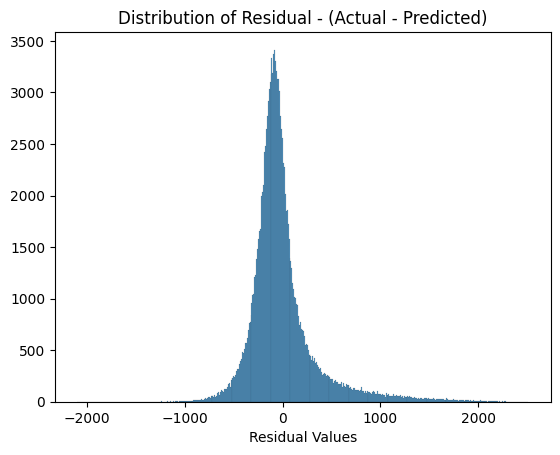

In [ ]:
residuals = y_test - predictions

sns.histplot(residuals)
plt.xlabel('Residual Values')
plt.ylabel('')
plt.title('Distribution of Residual - (Actual - Predicted)')
plt.show()

### Save/Pickle the model

In [ ]:
# model
with open('RM_Model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

print('Model Saved')

# scaler
with open('Scaler.pickle', 'wb') as to_write:
    pickle.dump(scaler, to_write)

print('Scaler Saved')

Model Saved
Scaler Saved


### Sample Predictions
Check out [Estimated Revenue] notebook for more predictions!

In [50]:
# use a sample row
single_trip = df.drop('ride_duration', axis=1).iloc[1]

# scale features
single_trip = scaler.transform(single_trip.values.reshape(-1,17))

# make predictions
xgb_cv.predict(single_trip)

array([409.21295], dtype=float32)

In [51]:
# Actual duration
df.iloc[1]['ride_duration']

349.0